In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from matplotlib.colors import ListedColormap

import seaborn as sns

import warnings

# Filter out FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

In [2]:
df_countries_codes = pd.read_csv('../environnement_data/countries_codes_and_coordinates.csv')
df_countries_codes = df_countries_codes.rename(columns = {'Alpha-3 code':'iso_a3'})
df_countries_codes['iso_a3'] = df_countries_codes['iso_a3'].apply(lambda x: x.replace('"', ''))
df_countries_codes['iso_a3'] = df_countries_codes['iso_a3'].apply(lambda x: x.replace(' ', ''))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
data = pd.read_csv('../environnement_data/ENS - Cultural Index - Countries Databases - consolidate_table.csv')
data = data[['region', 'region_code', 'iso_a3',  'min_date', 'max_date']].copy()


data['max_date'] = round(data['max_date'], 0)
data['max_date'][data['max_date']==1900] = 1850

#data = data[data['region']=='Greek World']
data = data.sort_values(['min_date', 'max_date'], ascending=(True, True))
data = data.reset_index(drop=True)

df_country_names = world[['name', 'iso_a3']].drop_duplicates().copy()
data = pd.merge(data, df_country_names, on = 'iso_a3')


# Group by iso_a3 and aggregate min and max dates
data = data.groupby(['region', 'region_code', 'iso_a3']).agg({'min_date': 'min', 'max_date': 'max'}).reset_index()
data['max_date'][(data['region']=='Greek World')&(data['max_date']==1500)] = 700
data['max_date'][(data['region']=='Greek World')&(data['max_date']==1850)] = 700
data['max_date'][(data['region']=='Greek World')&(data['max_date']==1400)] = 700

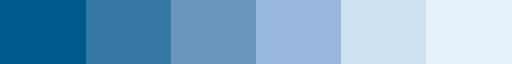

In [3]:
# Create a discrete colormap with shades of blue based on time
cmap = ListedColormap(['#005A8C', '#3477A5', '#6B95BD', '#99B8E0', '#CCE2F0', '#E6F2FA'])
cmap

In [4]:
def plot_region(data, region_code='re_italy', n = 10):

    data_filtered = data[data['region_code']==region_code]
    gdf = gpd.GeoDataFrame(data_filtered)


    # Iterate through region codes and plot maps
    for region_code, region_data in gdf.groupby('region'):


        # Merge with world map to get geometries
        merged_data = pd.merge(world, region_data, on='iso_a3')
        

        # Calculate the centroid of the region's geometries
        region_centroid = merged_data.geometry.unary_union.centroid

        # Plot the map centered around the region's centroid
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_title(region_code)

        # Set the aspect ratio to be equal for a square plot
        ax.set_aspect('equal')
        

        # Set the map extent based on the region's centroid
        ax.set_xlim([region_centroid.x - n, region_centroid.x + n])
        ax.set_ylim([region_centroid.y - n, region_centroid.y + n])

        ax.axis('off')  # Hide the axis
        
        merged_data['unique_date'] = merged_data['min_date'].astype(int).astype(str) + ' to ' +merged_data['max_date'].astype(int).astype(str)
        merged_data = merged_data.sort_values(['min_date', 'max_date'], ascending=(True, True))
        num_unique_pairs = len(set((merged_data['unique_date'])))
        
    
        # Check if there is only one color
        if num_unique_pairs == 1:
            colors = ["#005A8C"]  # Use the specific shade of blue
        else:
            # Automatically choose a gradient of blues
            colors = sns.color_palette("Blues", num_unique_pairs)

        # Create a ListedColormap
        cmap = ListedColormap(colors)

        world.boundary.plot(ax=ax, color='lightgrey')  # Plot the world map boundaries in black
        plot = merged_data.plot(ax=ax, 
                                cmap=cmap, 
                                edgecolor='black', 
                                column='unique_date',
                                cax=False,
                                legend=True)  # Plot the region data with shades of blue
        
        return plot        
        # Save or display the plot
        #plt.savefig(f'map_figures/map_{region_code}.png', bbox_inches='tight', pad_inches=0.1)
        #plt.show()  # Display the map


    # Close all plots
    #plt.close('all')

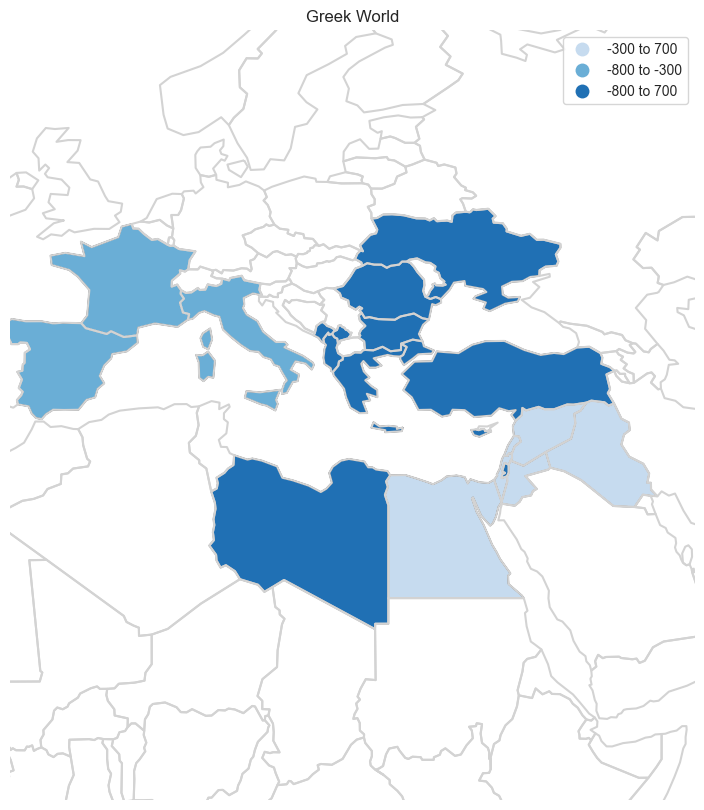

In [5]:
region_code = 're_greek_world'
plot = plot_region(data, region_code = region_code,n=30)

In [19]:
# greek world geometries
data_filtered = data[data['region_code']=="re_greek_world"]
gdf = gpd.GeoDataFrame(data_filtered)
greek_world_gdf = pd.merge(world, gdf, on='iso_a3')
greek_world_gdf

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,region,region_code,min_date,max_date
0,67059887.0,Europe,France,FRA,2715518,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...",Greek World,re_greek_world,-800.0,-300.0
1,9053300.0,Asia,Israel,ISR,394652,"POLYGON ((35.71992 32.70919, 35.54567 32.39399...",Greek World,re_greek_world,-300.0,700.0
2,6855713.0,Asia,Lebanon,LBN,51991,"POLYGON ((35.82110 33.27743, 35.55280 33.26427...",Greek World,re_greek_world,-300.0,700.0
3,4685306.0,Asia,Palestine,PSE,16276,"POLYGON ((35.39756 31.48909, 34.92741 31.35344...",Greek World,re_greek_world,-800.0,700.0
4,10101694.0,Asia,Jordan,JOR,44502,"POLYGON ((35.54567 32.39399, 35.71992 32.70919...",Greek World,re_greek_world,-300.0,700.0
5,39309783.0,Asia,Iraq,IRQ,234094,"POLYGON ((39.19547 32.16101, 38.79234 33.37869...",Greek World,re_greek_world,-300.0,700.0
6,17070135.0,Asia,Syria,SYR,98830,"POLYGON ((35.71992 32.70919, 35.70080 32.71601...",Greek World,re_greek_world,-300.0,700.0
7,44385155.0,Europe,Ukraine,UKR,153781,"POLYGON ((32.15944 52.06125, 32.41206 52.28869...",Greek World,re_greek_world,-800.0,700.0
8,19356544.0,Europe,Romania,ROU,250077,"POLYGON ((28.23355 45.48828, 28.67978 45.30403...",Greek World,re_greek_world,-800.0,700.0
9,6975761.0,Europe,Bulgaria,BGR,68558,"POLYGON ((22.65715 44.23492, 22.94483 43.82379...",Greek World,re_greek_world,-800.0,700.0


In [20]:
greek_world_gdf.to_file("greek_world_gdf.geojson", driver='GeoJSON')

In [14]:
# get unary union of all countries of the Greek world
re_greek_world_uu = merged_data.geometry.unary_union
type(re_greek_world_uu)

shapely.geometry.multipolygon.MultiPolygon

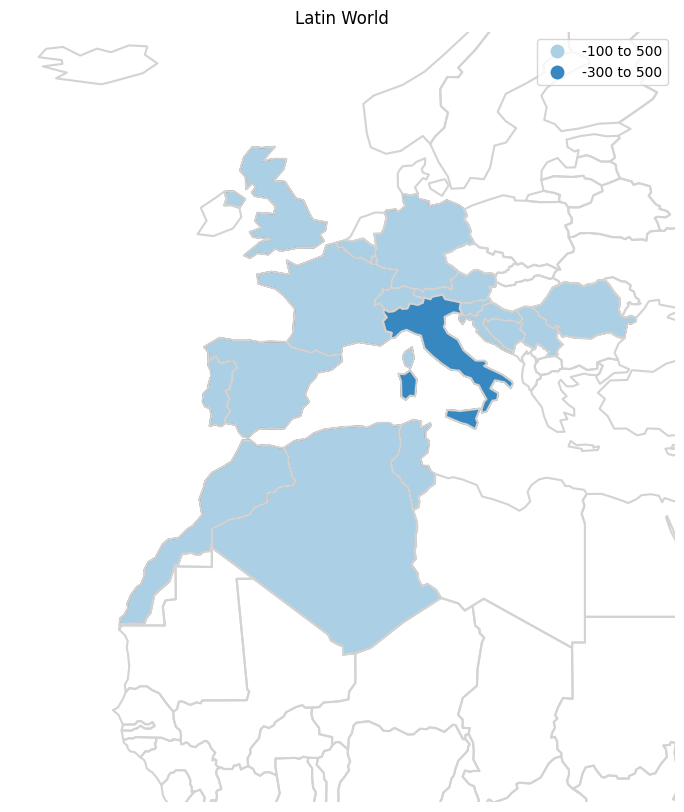

In [191]:
region_code = 're_latin'
plot = plot_region(data, region_code = region_code,n=30)
plt.savefig(f'map_figures_manual/map_{region_code}.png', bbox_inches='tight', pad_inches=0.1)

In [16]:
# latin world geodataframe
data_filtered = data[data['region_code']=="re_latin"]
gdf = gpd.GeoDataFrame(data_filtered)
latin_world_gdf = pd.merge(world, gdf, on='iso_a3')
latin_world_gdf

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,region,region_code,min_date,max_date
0,67059887.0,Europe,France,FRA,2715518,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...",Latin World,re_latin,-100.0,500.0
1,11694719.0,Africa,Tunisia,TUN,38796,"POLYGON ((9.48214 30.30756, 9.05560 32.10269, ...",Latin World,re_latin,-100.0,500.0
2,43053054.0,Africa,Algeria,DZA,171091,"POLYGON ((-8.68440 27.39574, -8.66512 27.58948...",Latin World,re_latin,-100.0,500.0
3,8877067.0,Europe,Austria,AUT,445075,"POLYGON ((16.97967 48.12350, 16.90375 47.71487...",Latin World,re_latin,-100.0,500.0
4,19356544.0,Europe,Romania,ROU,250077,"POLYGON ((28.23355 45.48828, 28.67978 45.30403...",Latin World,re_latin,-100.0,500.0
5,83132799.0,Europe,Germany,DEU,3861123,"POLYGON ((14.11969 53.75703, 14.35332 53.24817...",Latin World,re_latin,-100.0,500.0
6,4067500.0,Europe,Croatia,HRV,60752,"POLYGON ((16.56481 46.50375, 16.88252 46.38063...",Latin World,re_latin,-100.0,500.0
7,8574832.0,Europe,Switzerland,CHE,703082,"POLYGON ((9.59423 47.52506, 9.63293 47.34760, ...",Latin World,re_latin,-100.0,500.0
8,619896.0,Europe,Luxembourg,LUX,71104,"POLYGON ((6.04307 50.12805, 6.24275 49.90223, ...",Latin World,re_latin,-100.0,500.0
9,11484055.0,Europe,Belgium,BEL,533097,"POLYGON ((6.15666 50.80372, 6.04307 50.12805, ...",Latin World,re_latin,-100.0,500.0


In [21]:
latin_world_gdf.to_file("latin_world_gdf.geojson", driver="GeoJSON")

#### Draw One Map

In [201]:
import sys

sys.path.append('../')

from functions_env import DB_PATH
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [202]:
conn = sqlite3.connect(DB_PATH)

In [203]:
df_occupations = pd.read_sql_query("SELECT * FROM individual_occupations", conn)
df_occupations = df_occupations[df_occupations['occupations_category'].str.contains('science')]

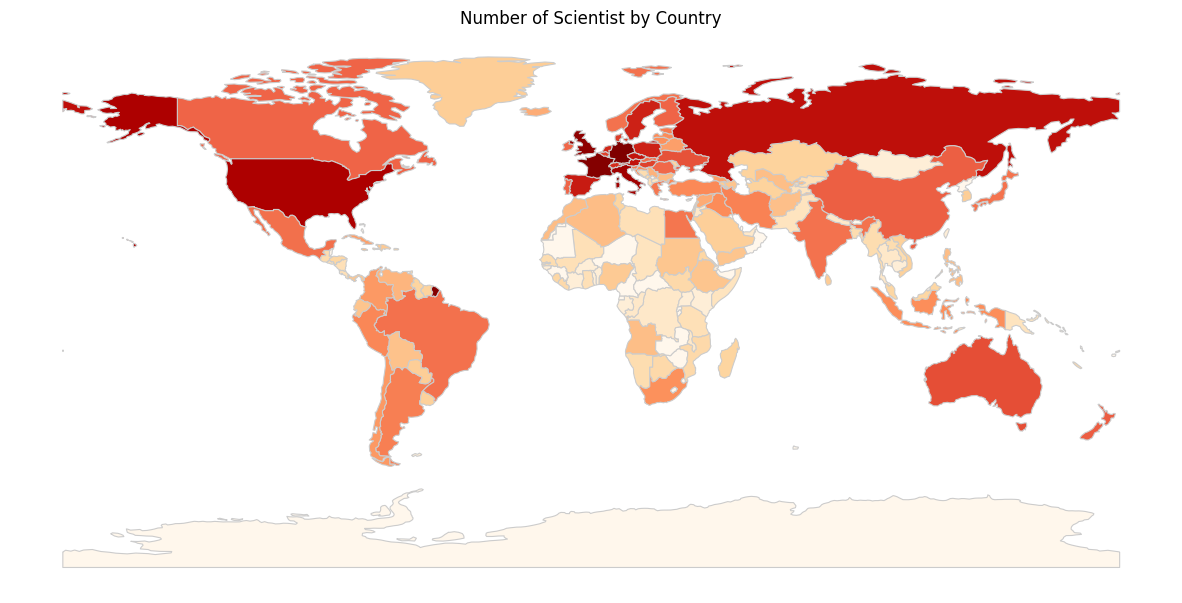

In [204]:
df_individual = pd.read_sql_query("SELECT * FROM individuals_main_information", conn)
df_individual = df_individual[['individual_wikidata_id', 'country_code', 'birthyear']]
df_individual = df_individual.dropna()
df_individual = df_individual[df_individual['birthyear']<=1850]

#kept_individuals =  pd.read_sql_query("SELECT * FROM individuals_kept", conn)
#kept_individuals = list(kept_individuals.individual_wikidata_id)

#df_final = df_individual[df_individual['individual_wikidata_id'].isin(kept_individuals)]
df_final = pd.merge(df_individual, df_occupations, on = 'individual_wikidata_id')



df_final = df_final.dropna()
df_final = df_final.rename(columns = {'country_code':'iso_a3'})

df_final = df_final.groupby('iso_a3')['individual_wikidata_id'].count().rename('count_individuals').reset_index()
df_final = df_final.sort_values('count_individuals', ascending=False)
#q = 100000

q = 100
df_final['bin'] = pd.cut(df_final['count_individuals'].rank(method= 'first'), bins=q, labels=list(np.arange(q)), precision=0)
df_final['bin'] = df_final['bin'].astype(int)
#df_final['bin'] = df_final['bin']+1

df_final['bin']= np.log(1+ df_final['count_individuals'])


# Merge the GeoDataFrame with the data
#gdf = pd.merge(df_final, world, on='iso_a3', how = 'outer')
#gdf['bin'][gdf['bin'].isna()] = 0

# Merge the GeoDataFrame with the data
gdf = world.merge(df_final, on='iso_a3', how = 'outer')
gdf = gdf.fillna(0)

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf.plot(column='bin', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=False)


# Hide x and y axis
ax.set_axis_off()

# Add legend on top right
##egend = ax.get_legend()
#legend.set_bbox_to_anchor((1, 1))

# Add labels and title
ax.set_title('Number of Scientist by Country')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()